In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### binary序列的规则
输入数据X：在时间t，$X_t$的值有50%的概率为1，50%的概率为0；  
输出数据Y：在时间t，$Y_t$的值有50%的概率为1，50%的概率为0，除此之外，还有两条规则：
* 规则1:如果$X_{t-3}$ == 1，$Y_t$为1的概率增加50%
* 规则2:如果$X_{t-8}$ == 1，则$Y_t$为1的概率减少25%， 如果上述两个条件同时满足，则$Y_t$为1的概率为75%。

In [2]:
def gen_data(size = 1000000, second_rule_idx = 8):
    X = np.array(np.random.choice(2, size=(size, )))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

### cross entropy

In [3]:
def cross_entropy(pro_list):
    sum = np.sum(-pro * np.log(pro) for pro in pro_list)
    return sum

In [4]:
Entropy_No_Train = cross_entropy([0.625, 1 - 0.625])
print("If not learning any rule, the cross entropy = %4f" % (Entropy_No_Train))
Entropy_Train_Rule_One = cross_entropy([0.875, 0.125]) * 0.5 + cross_entropy([0.625, 0.375]) * 0.5
print("If learning rule one, the cross entropy = %4f" % (Entropy_Train_Rule_One))
Entropy_Train_All_Rule = cross_entropy([0.75, 0.25]) * 0.5 + cross_entropy([0.5, 0.5]) * 0.25
print("If learning all rule, the cross entropy = %4f" % (Entropy_Train_All_Rule))

If not learning any rule, the cross entropy = 0.661563
If learning rule one, the cross entropy = 0.519167
If learning all rule, the cross entropy = 0.454454


### Batch

In [5]:
def gen_batch(raw, batch_size, num_steps):
    X, Y = raw
    X_length = len(X)
    
    batch_partition_length = X_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype = np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype = np.int32) 
    for i in range(batch_size):
        data_x[i] = X[batch_partition_length * i : batch_partition_length * (i+1)]
        data_y[i] = Y[batch_partition_length * i : batch_partition_length * (i+1)]

    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, num_steps * i: num_steps * (i+1)]
        y = data_y[:, num_steps * i: num_steps * (i+1)]
        yield(x, y)

In [6]:
def gen_epochs(n, num_steps, second_idx = 8):
    print(second_idx)
    for i in range(n):
        yield gen_batch(gen_data(second_rule_idx = second_idx), batch_size, num_steps)

### model

In [7]:
batch_size = 3
num_classes = 2
state_size = 16
learning_rate = 0.002
num_steps = 10

In [8]:
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='output_placeholder')

In [9]:
init_state = tf.zeros([batch_size, state_size])
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis = 1)

### Rnn cell

In [10]:
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer = tf.constant_initializer(0.0))
    
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse = True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer = tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [11]:
state = init_state
rnn_outputs = []

for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

### softmax

In [12]:
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer = tf.constant_initializer(0.0))

In [13]:
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

In [14]:
y_unstack = tf.unstack(y, axis=1)
losses =  [tf.nn.sparse_softmax_cross_entropy_with_logits(labels = label, logits = logit) \
    for logit, label in zip(logits, y_unstack)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss)

### Train

In [15]:
def train_network(num_epochs, verbose = True, second_idx = 8):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps, second_idx)):
            training_state = np.zeros((batch_size, state_size))
            training_loss = 0
            if verbose:
                print("\nEPOCH", idx)
            
            for step, (X, Y) in enumerate(epoch):
                
                tr_losses, training_loss_, training_state, _ = \
                    sess.run( [losses,total_loss,final_state,train_step],
                              feed_dict={x:X, y:Y, init_state:training_state})
                
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step ", step, " for last 100 steps:", training_loss / 100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
    
    return training_losses

### Result

In [16]:
training_losses = train_network(1)

8

EPOCH 0
Average loss at step  100  for last 100 steps: 0.742272976637
Average loss at step  200  for last 100 steps: 0.620792517066
Average loss at step  300  for last 100 steps: 0.578356666267
Average loss at step  400  for last 100 steps: 0.570386106074
Average loss at step  500  for last 100 steps: 0.552660898864
Average loss at step  600  for last 100 steps: 0.549843782485
Average loss at step  700  for last 100 steps: 0.537185618877
Average loss at step  800  for last 100 steps: 0.521604892313
Average loss at step  900  for last 100 steps: 0.521821700633
Average loss at step  1000  for last 100 steps: 0.522713835537
Average loss at step  1100  for last 100 steps: 0.519074311852
Average loss at step  1200  for last 100 steps: 0.50379158318
Average loss at step  1300  for last 100 steps: 0.513185833097
Average loss at step  1400  for last 100 steps: 0.500792761445
Average loss at step  1500  for last 100 steps: 0.511078546345
Average loss at step  1600  for last 100 steps: 0.5140

Average loss at step  13100  for last 100 steps: 0.48530619055
Average loss at step  13200  for last 100 steps: 0.482764700353
Average loss at step  13300  for last 100 steps: 0.470374871194
Average loss at step  13400  for last 100 steps: 0.491404855847
Average loss at step  13500  for last 100 steps: 0.483609328568
Average loss at step  13600  for last 100 steps: 0.479174692631
Average loss at step  13700  for last 100 steps: 0.469367487729
Average loss at step  13800  for last 100 steps: 0.473467061222
Average loss at step  13900  for last 100 steps: 0.479055738449
Average loss at step  14000  for last 100 steps: 0.469298233688
Average loss at step  14100  for last 100 steps: 0.483972832859
Average loss at step  14200  for last 100 steps: 0.47673127979
Average loss at step  14300  for last 100 steps: 0.480842702389
Average loss at step  14400  for last 100 steps: 0.483309702277
Average loss at step  14500  for last 100 steps: 0.478387848735
Average loss at step  14600  for last 100 

Average loss at step  26000  for last 100 steps: 0.481592034101
Average loss at step  26100  for last 100 steps: 0.470720101893
Average loss at step  26200  for last 100 steps: 0.477469372153
Average loss at step  26300  for last 100 steps: 0.476536405981
Average loss at step  26400  for last 100 steps: 0.477720379233
Average loss at step  26500  for last 100 steps: 0.483055192828
Average loss at step  26600  for last 100 steps: 0.479705676138
Average loss at step  26700  for last 100 steps: 0.470343339145
Average loss at step  26800  for last 100 steps: 0.484372113943
Average loss at step  26900  for last 100 steps: 0.477451891601
Average loss at step  27000  for last 100 steps: 0.470957258046
Average loss at step  27100  for last 100 steps: 0.468472120166
Average loss at step  27200  for last 100 steps: 0.46313203007
Average loss at step  27300  for last 100 steps: 0.458725501597
Average loss at step  27400  for last 100 steps: 0.474561680853
Average loss at step  27500  for last 100

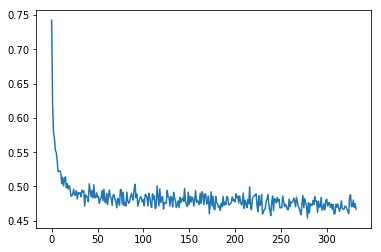

In [17]:
plt.plot(training_losses)
plt.show()

In [18]:
training_losses = train_network(1, second_idx = 5)

5

EPOCH 0
Average loss at step  100  for last 100 steps: 0.692814816833
Average loss at step  200  for last 100 steps: 0.668793393373
Average loss at step  300  for last 100 steps: 0.647911831737
Average loss at step  400  for last 100 steps: 0.639905466437
Average loss at step  500  for last 100 steps: 0.629963077307
Average loss at step  600  for last 100 steps: 0.612431703806
Average loss at step  700  for last 100 steps: 0.604673709869
Average loss at step  800  for last 100 steps: 0.600461531878
Average loss at step  900  for last 100 steps: 0.586775528193
Average loss at step  1000  for last 100 steps: 0.583437932134
Average loss at step  1100  for last 100 steps: 0.578215394318
Average loss at step  1200  for last 100 steps: 0.562915830016
Average loss at step  1300  for last 100 steps: 0.569999979734
Average loss at step  1400  for last 100 steps: 0.551043297648
Average loss at step  1500  for last 100 steps: 0.560187544227
Average loss at step  1600  for last 100 steps: 0.552

Average loss at step  13100  for last 100 steps: 0.485154924393
Average loss at step  13200  for last 100 steps: 0.490215238035
Average loss at step  13300  for last 100 steps: 0.473665801883
Average loss at step  13400  for last 100 steps: 0.483335472047
Average loss at step  13500  for last 100 steps: 0.485390028358
Average loss at step  13600  for last 100 steps: 0.485867257118
Average loss at step  13700  for last 100 steps: 0.49309692204
Average loss at step  13800  for last 100 steps: 0.488579553366
Average loss at step  13900  for last 100 steps: 0.486183079481
Average loss at step  14000  for last 100 steps: 0.493116939366
Average loss at step  14100  for last 100 steps: 0.489012809694
Average loss at step  14200  for last 100 steps: 0.471927202046
Average loss at step  14300  for last 100 steps: 0.474905755818
Average loss at step  14400  for last 100 steps: 0.475814082474
Average loss at step  14500  for last 100 steps: 0.47002804935
Average loss at step  14600  for last 100 

Average loss at step  26000  for last 100 steps: 0.486762501895
Average loss at step  26100  for last 100 steps: 0.475316224396
Average loss at step  26200  for last 100 steps: 0.473075286746
Average loss at step  26300  for last 100 steps: 0.477880786657
Average loss at step  26400  for last 100 steps: 0.481963812709
Average loss at step  26500  for last 100 steps: 0.472947643399
Average loss at step  26600  for last 100 steps: 0.479513393342
Average loss at step  26700  for last 100 steps: 0.478903036118
Average loss at step  26800  for last 100 steps: 0.474650253952
Average loss at step  26900  for last 100 steps: 0.458804207444
Average loss at step  27000  for last 100 steps: 0.467803621292
Average loss at step  27100  for last 100 steps: 0.475298628807
Average loss at step  27200  for last 100 steps: 0.483436170816
Average loss at step  27300  for last 100 steps: 0.475533187091
Average loss at step  27400  for last 100 steps: 0.475883714259
Average loss at step  27500  for last 10

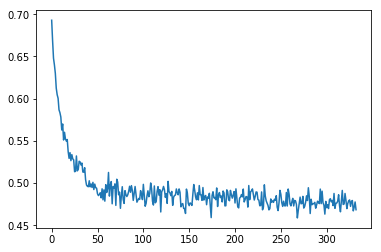

In [19]:
plt.plot(training_losses)
plt.show()